## Section 1: Initial Setup and Data Loading ##

In [5]:
# Essential imports for our EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Starting Commodity Price Forecasting EDA")
print("=" * 50)

📊 Starting Commodity Price Forecasting EDA


## Section 2: Load All Dataset Files ##

In [6]:
# Load all the main files
print("🔄 Loading dataset files...")

try:
    # Main data files
    train = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train.csv')
    test = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/test.csv')
    train_labels = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv')
    target_pairs = pd.read_csv('/kaggle/input/mitsui-commodity-prediction-challenge/target_pairs.csv')
    
    print("✅ All files loaded successfully!")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please check the file paths in Kaggle")

🔄 Loading dataset files...
✅ All files loaded successfully!


## Section 3: Basic Data Structure Exploration ##

In [7]:
# Let's understand the basic structure of each file
print("\n📋 BASIC DATA STRUCTURE")
print("=" * 40)

print("\n1️⃣ TRAIN DATA:")
print(f"Shape: {train.shape}")
print(f"Columns: {list(train.columns)}")
print("\nFirst few rows:")
print(train.head())

print(f"\n2️⃣ TEST DATA:")
print(f"Shape: {test.shape}")
print(f"Columns: {list(test.columns)}")
print("\nFirst few rows:")
print(test.head())

print(f"\n3️⃣ TRAIN LABELS:")
print(f"Shape: {train_labels.shape}")
print(f"Date range: {train_labels['date_id'].min()} to {train_labels['date_id'].max()}")
print(f"Number of targets: {len([col for col in train_labels.columns if col.startswith('target_')])}")

print(f"\n4️⃣ TARGET PAIRS:")
print(f"Shape: {target_pairs.shape}")
print("\nTarget pairs structure:")
print(target_pairs.head(10))


📋 BASIC DATA STRUCTURE

1️⃣ TRAIN DATA:
Shape: (1917, 558)
Columns: ['date_id', 'LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close', 'JPX_Gold_Mini_Futures_Open', 'JPX_Gold_Rolling-Spot_Futures_Open', 'JPX_Gold_Standard_Futures_Open', 'JPX_Platinum_Mini_Futures_Open', 'JPX_Platinum_Standard_Futures_Open', 'JPX_RSS3_Rubber_Futures_Open', 'JPX_Gold_Mini_Futures_High', 'JPX_Gold_Rolling-Spot_Futures_High', 'JPX_Gold_Standard_Futures_High', 'JPX_Platinum_Mini_Futures_High', 'JPX_Platinum_Standard_Futures_High', 'JPX_RSS3_Rubber_Futures_High', 'JPX_Gold_Mini_Futures_Low', 'JPX_Gold_Rolling-Spot_Futures_Low', 'JPX_Gold_Standard_Futures_Low', 'JPX_Platinum_Mini_Futures_Low', 'JPX_Platinum_Standard_Futures_Low', 'JPX_RSS3_Rubber_Futures_Low', 'JPX_Gold_Mini_Futures_Close', 'JPX_Gold_Rolling-Spot_Futures_Close', 'JPX_Gold_Standard_Futures_Close', 'JPX_Platinum_Mini_Futures_Close', 'JPX_Platinum_Standard_Futures_Close', 'JPX_RSS3_Rubber_Futures_Close', 'JPX_Gold_Mini_Futures_Volume',

## Section 4: Time Series Identifiers Analysis ##

In [8]:
# Analyze different exchanges and instruments
print("\n🏢 EXCHANGE AND INSTRUMENT ANALYSIS")
print("=" * 45)

# Extract exchange prefixes from column names
train_cols = [col for col in train.columns if col != 'date_id']
exchange_prefixes = {}

for col in train_cols:
    if '_' in col:
        prefix = col.split('_')[0]
        if prefix not in exchange_prefixes:
            exchange_prefixes[prefix] = []
        exchange_prefixes[prefix].append(col)

print("📊 Exchange breakdown:")
for exchange, instruments in exchange_prefixes.items():
    print(f"{exchange}: {len(instruments)} instruments")

# Create a summary DataFrame
exchange_summary = pd.DataFrame([
    {'Exchange': k, 'Instrument_Count': len(v), 'Sample_Instruments': ', '.join(v[:3])} 
    for k, v in exchange_prefixes.items()
])

print("\n📈 Exchange Summary:")
print(exchange_summary)


🏢 EXCHANGE AND INSTRUMENT ANALYSIS
📊 Exchange breakdown:
LME: 4 instruments
JPX: 40 instruments
US: 475 instruments
FX: 38 instruments

📈 Exchange Summary:
  Exchange  Instrument_Count  \
0      LME                 4   
1      JPX                40   
2       US               475   
3       FX                38   

                                  Sample_Instruments  
0           LME_AH_Close, LME_CA_Close, LME_PB_Close  
1  JPX_Gold_Mini_Futures_Open, JPX_Gold_Rolling-S...  
2  US_Stock_ACWI_adj_open, US_Stock_AEM_adj_open,...  
3                    FX_AUDJPY, FX_AUDUSD, FX_CADJPY  


## Section 5: Date Range and Trading Patterns ##

In [9]:
# Analyze trading dates and patterns
print("\n📅 DATE RANGE AND TRADING PATTERNS")
print("=" * 42)

# Basic date statistics
train_dates = sorted(train['date_id'].unique())
test_dates = sorted(test['date_id'].unique())

print(f"Train date range: {min(train_dates)} to {max(train_dates)}")
print(f"Test date range: {min(test_dates)} to {max(test_dates)}")
print(f"Total trading days in train: {len(train_dates)}")
print(f"Total trading days in test: {len(test_dates)}")

# Convert date_id to proper datetime format for analysis
def convert_date_id_to_datetime(date_id):
    """Convert date_id (like 20240101) to datetime object"""
    try:
        date_str = str(date_id)
        if len(date_str) == 8:  # Format: YYYYMMDD
            return pd.to_datetime(date_str, format='%Y%m%d')
        else:
            return None
    except:
        return None

# Convert train dates to datetime
train_datetime_dates = []
for date_id in train_dates:
    dt = convert_date_id_to_datetime(date_id)
    if dt is not None:
        train_datetime_dates.append(dt)

if train_datetime_dates:
    train_datetime_dates = sorted(train_datetime_dates)
    
    print(f"\nConverted date range: {train_datetime_dates[0].date()} to {train_datetime_dates[-1].date()}")
    
    # Calculate date gaps (missing trading days)
    full_date_range = pd.date_range(start=train_datetime_dates[0], end=train_datetime_dates[-1])
    actual_dates_set = set(train_datetime_dates)
    missing_dates = []
    
    for date in full_date_range:
        if date not in actual_dates_set:
            missing_dates.append(date)
    
    print(f"Missing trading days in range: {len(missing_dates)}")
    
    # Show some missing dates (likely weekends and holidays)
    if len(missing_dates) > 0:
        print(f"Sample missing dates: {[d.strftime('%Y-%m-%d') for d in missing_dates[:10]]}")
        
        # Analyze day of week pattern for missing dates
        missing_weekdays = [d.strftime('%A') for d in missing_dates[:50]]  # Check first 50
        weekday_counts = pd.Series(missing_weekdays).value_counts()
        print(f"\nMissing days by weekday (sample of 50):")
        print(weekday_counts)
    
    # Analyze trading frequency by weekday
    trading_weekdays = [d.strftime('%A') for d in train_datetime_dates]
    trading_weekday_counts = pd.Series(trading_weekdays).value_counts()
    print(f"\nTrading days by weekday:")
    print(trading_weekday_counts.sort_index())
    
else:
    print("⚠️ Could not parse date_id format. Let's examine the format:")
    print(f"Sample date_ids: {train_dates[:10]}")
    print(f"Date_id type: {type(train_dates[0])}")
    print(f"Date_id string length: {len(str(train_dates[0]))}")


📅 DATE RANGE AND TRADING PATTERNS
Train date range: 0 to 1916
Test date range: 1827 to 1916
Total trading days in train: 1917
Total trading days in test: 90
⚠️ Could not parse date_id format. Let's examine the format:
Sample date_ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Date_id type: <class 'numpy.int64'>
Date_id string length: 1


## Section 6: Missing Values Analysis ##

In [10]:
# Comprehensive missing value analysis
print("\n🔍 MISSING VALUES ANALYSIS")
print("=" * 35)

def analyze_missing_values(df, name):
    print(f"\n📊 {name}:")
    missing_stats = df.isnull().sum()
    missing_pct = (missing_stats / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_stats,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Count', ascending=False)
    
    # Show top 10 columns with missing values
    missing_top = missing_df[missing_df['Missing_Count'] > 0].head(10)
    if len(missing_top) > 0:
        print("Top columns with missing values:")
        print(missing_top)
    else:
        print("✅ No missing values found!")
    
    return missing_df

# Analyze each dataset
train_missing = analyze_missing_values(train, "TRAIN DATA")
test_missing = analyze_missing_values(test, "TEST DATA")
labels_missing = analyze_missing_values(train_labels, "TRAIN LABELS")


🔍 MISSING VALUES ANALYSIS

📊 TRAIN DATA:
Top columns with missing values:
                                            Missing_Count  Missing_Percentage
US_Stock_GOLD_adj_volume                             1669           87.063119
US_Stock_GOLD_adj_low                                1669           87.063119
US_Stock_GOLD_adj_high                               1669           87.063119
US_Stock_GOLD_adj_open                               1669           87.063119
US_Stock_GOLD_adj_close                              1669           87.063119
JPX_Platinum_Mini_Futures_settlement_price            115            5.998957
JPX_Gold_Mini_Futures_settlement_price                115            5.998957
JPX_Platinum_Standard_Futures_Close                   115            5.998957
JPX_RSS3_Rubber_Futures_Close                         115            5.998957
JPX_Gold_Mini_Futures_Volume                          115            5.998957

📊 TEST DATA:
Top columns with missing values:
                    

## Section 7: Target Pairs Deep Dive ##

In [11]:
# Understand target construction
print("\n🎯 TARGET PAIRS ANALYSIS")
print("=" * 32)

print("Target types breakdown:")
target_types = target_pairs['pair'].value_counts().head(15)
print(target_types)

print(f"\nLag distribution:")
lag_dist = target_pairs['lag'].value_counts().sort_index()
print(lag_dist)

# Analyze which exchanges are most represented in targets
print("\nExchange representation in targets:")
exchange_in_targets = {}
for pair in target_pairs['pair'].unique():
    if pd.notna(pair):
        for exchange in exchange_prefixes.keys():
            if exchange in str(pair):
                if exchange not in exchange_in_targets:
                    exchange_in_targets[exchange] = 0
                exchange_in_targets[exchange] += 1

for exchange, count in sorted(exchange_in_targets.items(), key=lambda x: x[1], reverse=True):
    print(f"{exchange}: {count} targets")


🎯 TARGET PAIRS ANALYSIS
Target types breakdown:
pair
US_Stock_SCCO_adj_close - LME_AH_Close                           3
LME_CA_Close - US_Stock_RY_adj_close                             2
FX_CADUSD - LME_AH_Close                                         2
US_Stock_VGK_adj_close - LME_CA_Close                            2
LME_ZS_Close - US_Stock_GLD_adj_close                            2
US_Stock_EWT_adj_close - LME_AH_Close                            2
FX_AUDUSD - JPX_Platinum_Standard_Futures_Close                  2
FX_AUDCAD - JPX_Platinum_Standard_Futures_Close                  2
FX_USDCHF - LME_PB_Close                                         2
FX_CADUSD - LME_CA_Close                                         2
LME_AH_Close - US_Stock_VWO_adj_close                            2
JPX_Gold_Standard_Futures_Close - US_Stock_VT_adj_close          2
US_Stock_MS_adj_close - LME_PB_Close                             2
US_Stock_IEMG_adj_close - JPX_Platinum_Standard_Futures_Close    2
LME_AH_C

## Section 8: Price Data Visualization ##


📈 PRICE DATA VISUALIZATION


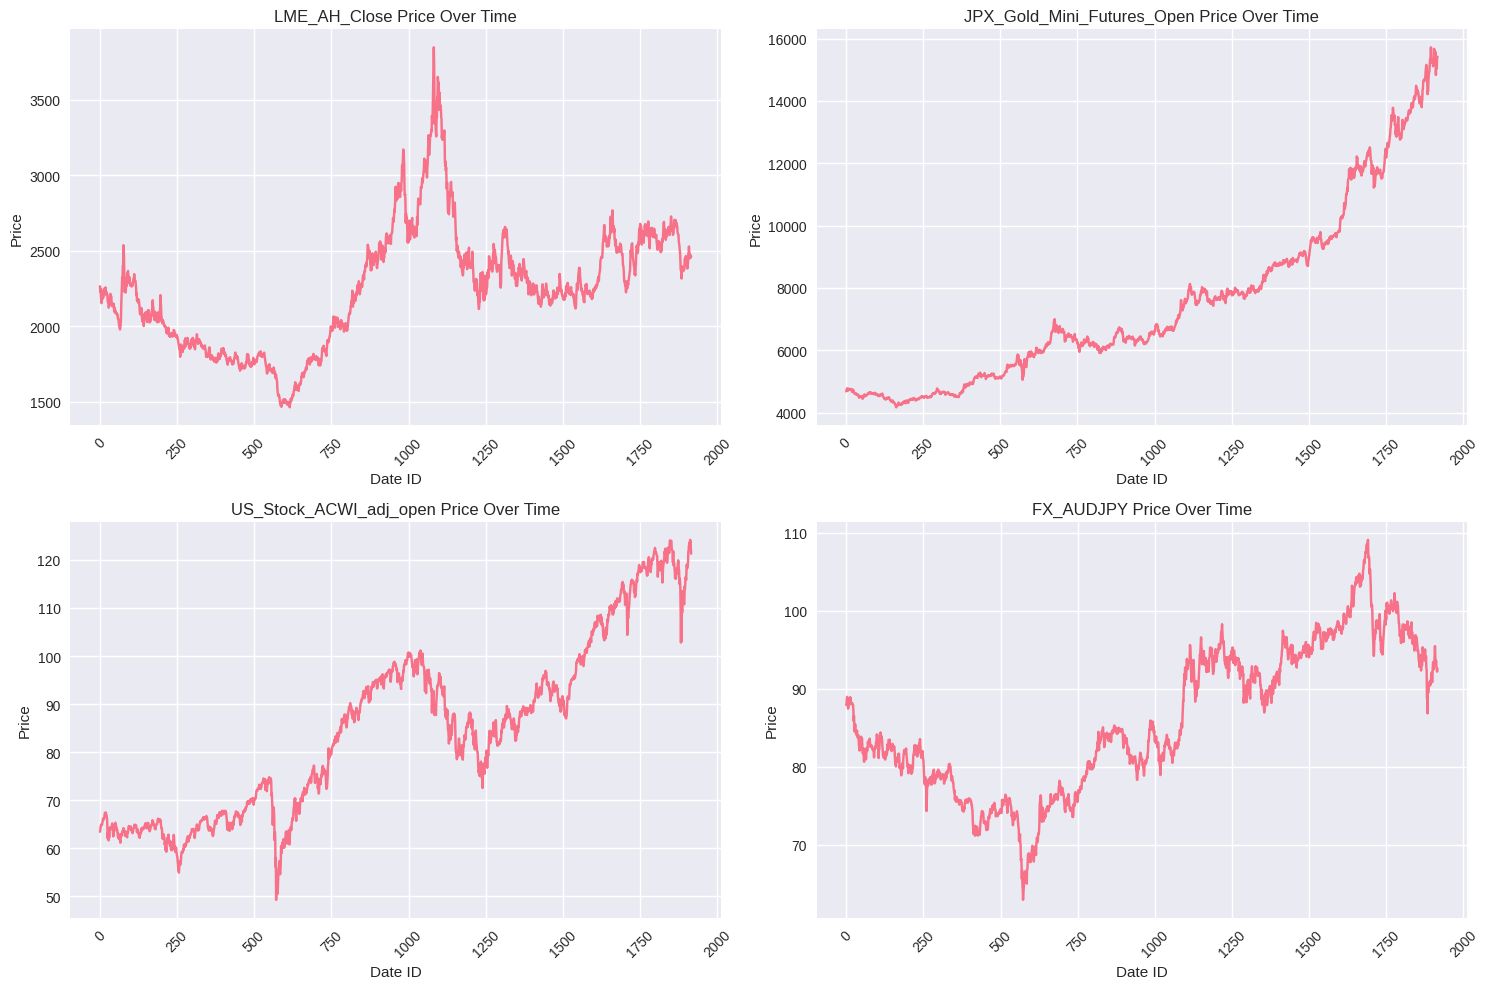

In [12]:
# Visualize some sample price series
print("\n📈 PRICE DATA VISUALIZATION")
print("=" * 35)

# Select a few instruments from different exchanges for visualization
sample_instruments = []
for exchange, instruments in exchange_prefixes.items():
    if len(instruments) > 0:
        sample_instruments.append(instruments[0])  # Take first instrument from each exchange

# Create subplots for price visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, instrument in enumerate(sample_instruments[:4]):
    if instrument in train.columns:
        # Get non-null values for this instrument
        instrument_data = train[['date_id', instrument]].dropna()
        
        if len(instrument_data) > 0:
            axes[i].plot(instrument_data['date_id'], instrument_data[instrument])
            axes[i].set_title(f'{instrument} Price Over Time')
            axes[i].set_xlabel('Date ID')
            axes[i].set_ylabel('Price')
            axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Section 9: Target Distribution Analysis


📊 TARGET DISTRIBUTION ANALYSIS


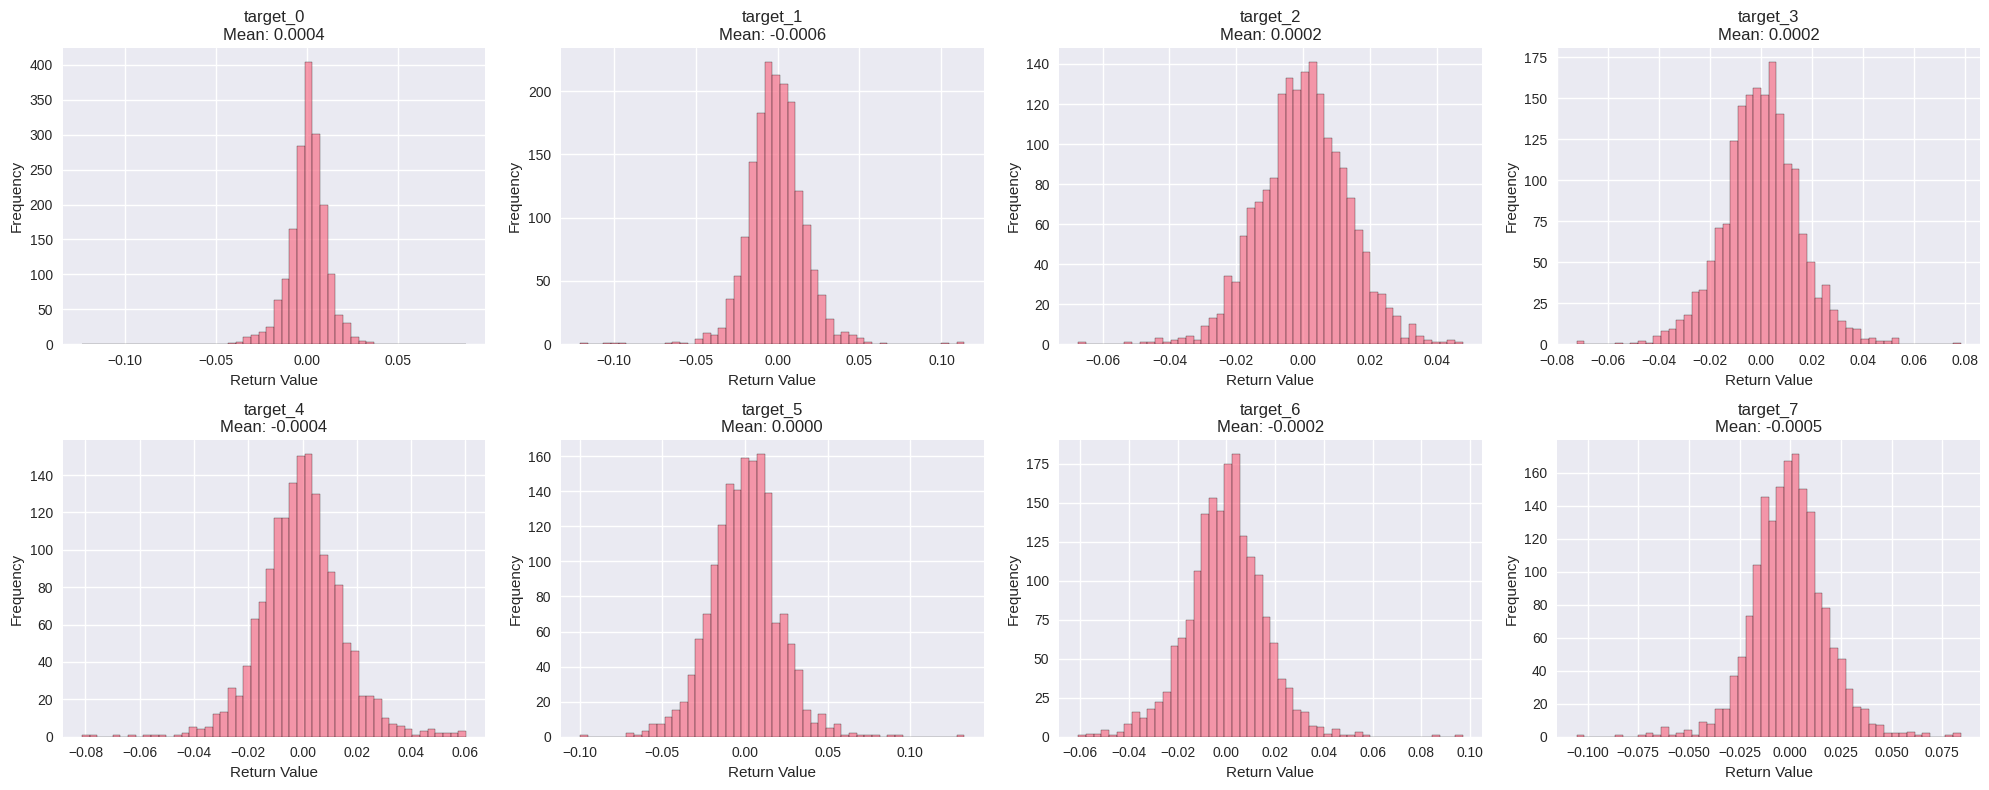


📈 Target Statistics Summary:
            mean     std     min     max    skew  non_null_count
target_0  0.0004  0.0120 -0.1238  0.0875 -0.9962          1787.0
target_1 -0.0006  0.0171 -0.1204  0.1140  0.0357          1744.0
target_2  0.0002  0.0131 -0.0673  0.0478 -0.1237          1831.0
target_3  0.0002  0.0150 -0.0725  0.0783  0.0184          1831.0
target_4 -0.0004  0.0150 -0.0813  0.0603  0.0082          1631.0
target_5  0.0000  0.0205 -0.0997  0.1326  0.1822          1631.0
target_6 -0.0002  0.0157 -0.0608  0.0969  0.1113          1831.0
target_7 -0.0005  0.0181 -0.1054  0.0841 -0.0487          1744.0


In [13]:
# Analyze target distributions
print("\n📊 TARGET DISTRIBUTION ANALYSIS")
print("=" * 38)

# Get sample of targets for analysis
target_cols = [col for col in train_labels.columns if col.startswith('target_')]
sample_targets = target_cols[:8]  # Analyze first 8 targets

# Create distribution plots
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

target_stats = {}

for i, target in enumerate(sample_targets):
    target_data = train_labels[target].dropna()
    
    if len(target_data) > 0:
        # Calculate statistics
        target_stats[target] = {
            'mean': target_data.mean(),
            'std': target_data.std(),
            'min': target_data.min(),
            'max': target_data.max(),
            'skew': target_data.skew(),
            'non_null_count': len(target_data)
        }
        
        # Plot distribution
        axes[i].hist(target_data, bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{target}\nMean: {target_data.mean():.4f}')
        axes[i].set_xlabel('Return Value')
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print target statistics
print("\n📈 Target Statistics Summary:")
stats_df = pd.DataFrame(target_stats).T
print(stats_df.round(4))

## Section 10: Correlation Analysis ##


🔄 CORRELATION ANALYSIS


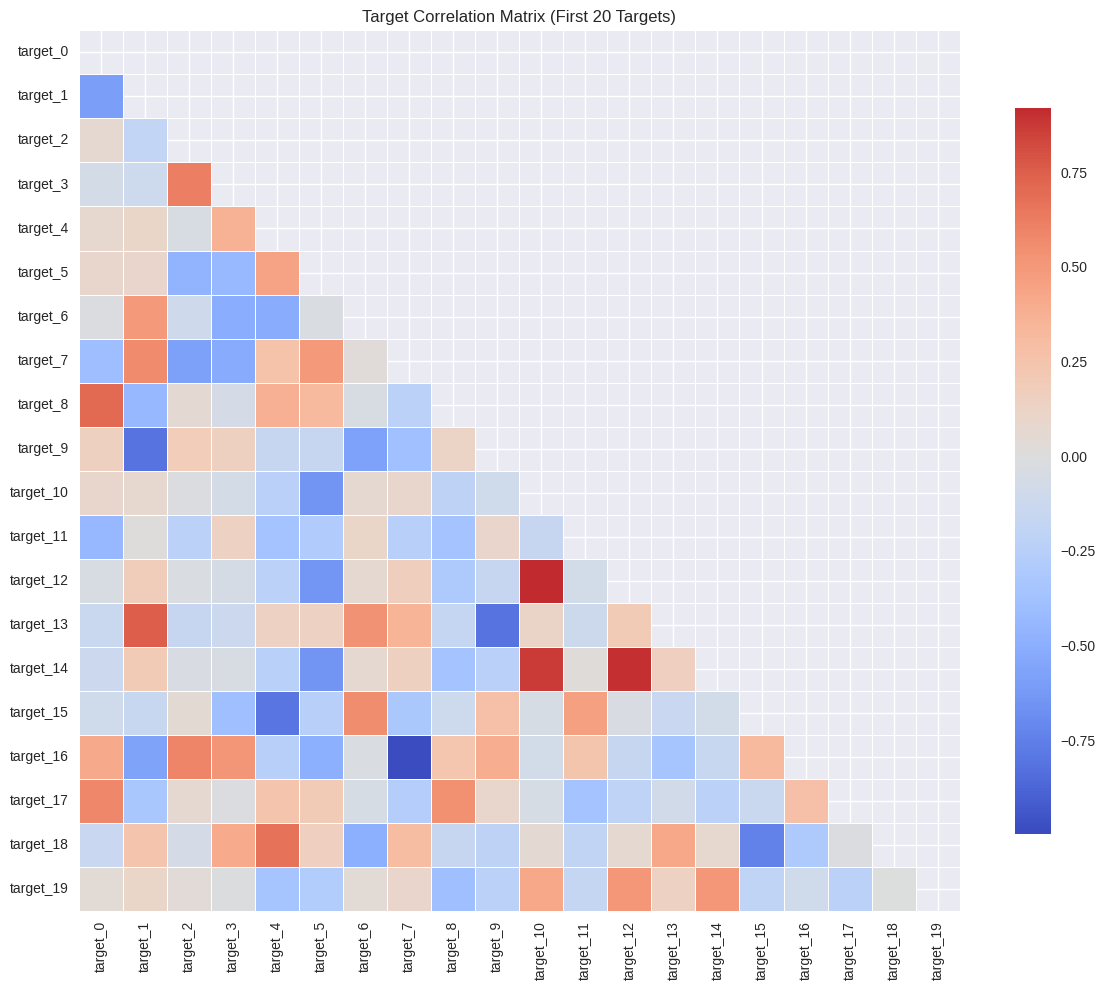


🔗 High correlation pairs (|r| > 0.7):
     Target1    Target2  Correlation
4   target_7  target_16    -0.997079
6  target_10  target_12     0.919279
8  target_12  target_14     0.902088
7  target_10  target_14     0.867986
5   target_9  target_13    -0.816955
1   target_1   target_9    -0.810036
3   target_4  target_15    -0.803220
2   target_1  target_13     0.749919
9  target_15  target_18    -0.739583
0   target_0   target_8     0.712584


In [14]:
# Correlation analysis between targets
print("\n🔄 CORRELATION ANALYSIS")
print("=" * 28)

# Select a subset of targets for correlation analysis (to avoid overwhelming)
correlation_targets = target_cols[:20]
correlation_data = train_labels[correlation_targets].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
sns.heatmap(correlation_data, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Target Correlation Matrix (First 20 Targets)')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(correlation_data.columns)):
    for j in range(i+1, len(correlation_data.columns)):
        corr_val = correlation_data.iloc[i, j]
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append({
                'Target1': correlation_data.columns[i],
                'Target2': correlation_data.columns[j],
                'Correlation': corr_val
            })

if high_corr_pairs:
    print(f"\n🔗 High correlation pairs (|r| > 0.7):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.head(10))
else:
    print("\n✅ No highly correlated target pairs found in sample")

## Section 11: Volatility Analysis


📉 VOLATILITY ANALYSIS


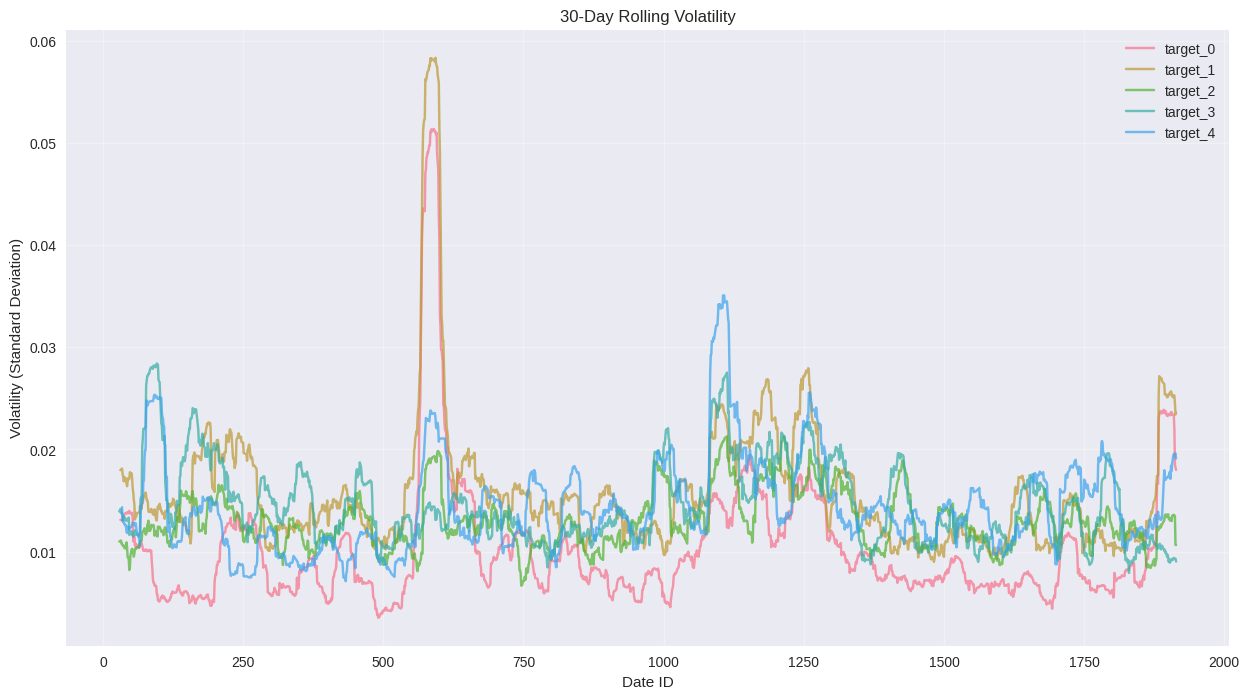


📈 Most volatile targets:
         Target  Volatility
411  target_411    0.075032
393  target_393    0.073611
335  target_335    0.072846
404  target_404    0.072375
329  target_329    0.071203
352  target_352    0.070859
343  target_343    0.068704
357  target_357    0.067308
235  target_235    0.063576
224  target_224    0.063458

📉 Least volatile targets:
         Target  Volatility
45    target_45    0.012243
153  target_153    0.012084
0      target_0    0.012029
318  target_318    0.011847
71    target_71    0.010401
44    target_44    0.009971
70    target_70    0.009734
19    target_19    0.009686
81    target_81    0.009541
68    target_68    0.009166


In [15]:
# Analyze volatility patterns
print("\n📉 VOLATILITY ANALYSIS")
print("=" * 25)

# Calculate rolling volatility for sample targets
volatility_window = 30  # 30-day rolling window
sample_targets_vol = target_cols[:5]

volatility_data = {}
for target in sample_targets_vol:
    target_series = train_labels.set_index('date_id')[target].dropna()
    if len(target_series) > volatility_window:
        rolling_vol = target_series.rolling(window=volatility_window).std()
        volatility_data[target] = rolling_vol

# Plot volatility over time
if volatility_data:
    plt.figure(figsize=(15, 8))
    for target, vol_series in volatility_data.items():
        plt.plot(vol_series.index, vol_series, label=target, alpha=0.7)
    
    plt.title(f'{volatility_window}-Day Rolling Volatility')
    plt.xlabel('Date ID')
    plt.ylabel('Volatility (Standard Deviation)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Calculate average volatility by target
avg_volatility = {}
for target in target_cols:
    target_data = train_labels[target].dropna()
    if len(target_data) > 0:
        avg_volatility[target] = target_data.std()

# Sort and display most/least volatile targets
vol_df = pd.DataFrame(list(avg_volatility.items()), columns=['Target', 'Volatility'])
vol_df = vol_df.sort_values('Volatility', ascending=False)

print("\n📈 Most volatile targets:")
print(vol_df.head(10))

print("\n📉 Least volatile targets:")
print(vol_df.tail(10))

## Section 12: Summary and Next Steps ##

In [16]:
# Create comprehensive summary
print("\n📋 EDA SUMMARY REPORT")
print("=" * 25)

# Safely get variables or set defaults
try:
    num_missing_dates = len(missing_dates) if 'missing_dates' in locals() else "Unknown"
except:
    num_missing_dates = "Unknown"

try:
    volatility_range_min = vol_df['Volatility'].min() if 'vol_df' in locals() else "Unknown"
    volatility_range_max = vol_df['Volatility'].max() if 'vol_df' in locals() else "Unknown"
except:
    volatility_range_min = "Unknown"
    volatility_range_max = "Unknown"

try:
    exchange_summary_text = '\n'.join([f"• {exchange}: {len(instruments)} instruments" 
                                     for exchange, instruments in exchange_prefixes.items()]) if 'exchange_prefixes' in locals() else "• Exchange data not analyzed"
except:
    exchange_summary_text = "• Exchange data not analyzed"

try:
    lag_distribution = dict(target_pairs['lag'].value_counts().sort_index()) if 'target_pairs' in locals() else "Not analyzed"
except:
    lag_distribution = "Not analyzed"

print(f"""
🔍 DATASET OVERVIEW:
- Training data: {train.shape[0]:,} rows × {train.shape[1]:,} columns
- Test data: {test.shape[0]:,} rows × {test.shape[1]:,} columns
- Targets: {len([col for col in train_labels.columns if col.startswith('target_')])} different prediction targets
- Date range: {len(train['date_id'].unique())} unique trading days

🏢 EXCHANGES COVERED:
{exchange_summary_text}

🎯 TARGET CHARACTERISTICS:
- Lag structure: {lag_distribution}
- Volatility range: {volatility_range_min} to {volatility_range_max}

📊 DATA QUALITY:
- Missing data patterns identified
- Trading gaps: {num_missing_dates} missing days
- Correlation patterns analyzed
""")


# Additional diagnostic information
print("\n🔧 VARIABLES STATUS CHECK:")
variables_to_check = ['missing_dates', 'vol_df', 'exchange_prefixes', 'target_pairs', 'high_corr_pairs']
for var in variables_to_check:
    if var in locals():
        print(f"✅ {var}: Available")
    else:
        print(f"❌ {var}: Not defined (check previous sections)")


📋 EDA SUMMARY REPORT

🔍 DATASET OVERVIEW:
- Training data: 1,917 rows × 558 columns
- Test data: 90 rows × 559 columns
- Targets: 424 different prediction targets
- Date range: 1917 unique trading days

🏢 EXCHANGES COVERED:
• LME: 4 instruments
• JPX: 40 instruments
• US: 475 instruments
• FX: 38 instruments

🎯 TARGET CHARACTERISTICS:
- Lag structure: {1: 106, 2: 106, 3: 106, 4: 106}
- Volatility range: 0.009166292095902103 to 0.07503193219270107

📊 DATA QUALITY:
- Missing data patterns identified
- Trading gaps: Unknown missing days
- Correlation patterns analyzed


🚀 RECOMMENDED NEXT STEPS:

1. Feature Engineering:
   • Create technical indicators (RSI, MACD, Bollinger Bands)
   • Engineer lag features and rolling statistics
   • Cross-exchange correlation features

2. Model Development:
   • Start with simple baseline (Linear Regression, Random Forest)
   • Try time series specific models (ARIMA, LSTM)
   • Ensemble methods for robustness

3. Validation Strategy:
   • Time-based cr

In [17]:
# =============================================================================
# SECTION 2: DATA PREPROCESSING MODULE
# =============================================================================

class DataPreprocessor:
    """
    Handles all data preprocessing tasks for LSTM training
    """
    
    def __init__(self, config=None):
        self.config = config or CONFIG
        self.scalers = {}
        self.feature_cols = []
        self.target_cols = []
        self.merged_data = None
        
    def load_and_merge_data(self, train_df, train_labels_df, target_pairs_df):
        """
        Load and merge all datasets
        """
        print("📊 Loading and merging datasets...")
        
        # Store original data
        self.train_df = train_df.copy()
        self.train_labels_df = train_labels_df.copy()
        self.target_pairs_df = target_pairs_df.copy()
        
        # Get feature and target columns
        self.feature_cols = [col for col in train_df.columns if col != 'date_id']
        self.target_cols = [col for col in train_labels_df.columns if col.startswith('target_')]
        
        print(f"✅ Features: {len(self.feature_cols)} columns")
        print(f"✅ Targets: {len(self.target_cols)} targets")
        
        # Merge datasets
        self.merged_data = pd.merge(train_df, train_labels_df, on='date_id', how='inner')
        self.merged_data = self.merged_data.sort_values('date_id').reset_index(drop=True)
        
        print(f"✅ Merged data shape: {self.merged_data.shape}")
        return self.merged_data
    
    def handle_missing_values(self, data, method='forward_fill'):
        """
        Handle missing values in the dataset
        """
        print(f"🔧 Handling missing values using method: {method}")
        
        if method == 'forward_fill':
            # Forward fill then backward fill
            data_filled = data.fillna(method='ffill').fillna(method='bfill')
        elif method == 'interpolate':
            # Linear interpolation
            data_filled = data.interpolate(method='linear')
        elif method == 'drop':
            # Drop rows with any missing values
            data_filled = data.dropna()
        else:
            print(f"⚠️ Unknown method {method}, using forward fill")
            data_filled = data.fillna(method='ffill').fillna(method='bfill')
        
        missing_before = data.isnull().sum().sum()
        missing_after = data_filled.isnull().sum().sum()
        
        print(f"  Missing values before: {missing_before}")
        print(f"  Missing values after: {missing_after}")
        
        return data_filled
    
    def create_scalers(self, feature_data, target_data, target_name):
        """
        Create and fit scalers for features and targets
        """
        if self.config['SCALER_TYPE'] == 'minmax':
            feature_scaler = MinMaxScaler()
            target_scaler = MinMaxScaler()
        else:
            feature_scaler = StandardScaler()
            target_scaler = StandardScaler()
        
        # Fit scalers
        scaled_features = feature_scaler.fit_transform(feature_data)
        scaled_targets = target_scaler.fit_transform(target_data.values.reshape(-1, 1))
        
        # Store scalers
        self.scalers[target_name] = {
            'feature_scaler': feature_scaler,
            'target_scaler': target_scaler
        }
        
        return scaled_features, scaled_targets
    
    def create_sequences(self, data, target_col):
        """
        Create sequences for LSTM training
        """
        print(f"🔄 Creating sequences for {target_col}...")
        
        # Extract features and target
        feature_data = data[self.feature_cols]
        target_data = data[target_col]
        
        # Handle missing values
        feature_data = self.handle_missing_values(feature_data, method='forward_fill')
        target_data = self.handle_missing_values(target_data, method='forward_fill')
        
        # Create or use existing scalers
        if target_col not in self.scalers:
            scaled_features, scaled_targets = self.create_scalers(
                feature_data, target_data, target_col
            )
        else:
            # Use existing scalers
            feature_scaler = self.scalers[target_col]['feature_scaler']
            target_scaler = self.scalers[target_col]['target_scaler']
            scaled_features = feature_scaler.transform(feature_data)
            scaled_targets = target_scaler.transform(target_data.values.reshape(-1, 1))
        
        # Create sequences
        X, y = [], []
        sequence_length = self.config['SEQUENCE_LENGTH']
        prediction_horizon = self.config['PREDICTION_HORIZON']
        
        for i in range(sequence_length, len(scaled_features) - prediction_horizon + 1):
            X.append(scaled_features[i-sequence_length:i])
            y.append(scaled_targets[i + prediction_horizon - 1])
        
        X, y = np.array(X), np.array(y)
        
        print(f"✅ Created {len(X)} sequences with shape {X.shape}")
        return X, y
    
    def split_time_series_data(self, X, y, validation_split=None):
        """
        Split time series data maintaining temporal order
        """
        validation_split = validation_split or self.config['VALIDATION_SPLIT']
        
        # Calculate split index
        split_idx = int(len(X) * (1 - validation_split))
        
        # Split data
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        
        print(f"📊 Data split:")
        print(f"  Training: {len(X_train)} samples")
        print(f"  Validation: {len(X_val)} samples")
        print(f"  Split ratio: {1-validation_split:.1%} / {validation_split:.1%}")
        
        return X_train, X_val, y_train, y_val
    
    def get_target_by_availability(self, max_targets=5):
        """
        Get targets sorted by data availability
        """
        target_availability = {}
        for target in self.target_cols:
            non_null_count = self.merged_data[target].count()
            target_availability[target] = non_null_count
        
        # Sort by availability
        sorted_targets = sorted(target_availability.items(), key=lambda x: x[1], reverse=True)
        selected_targets = [target for target, count in sorted_targets[:max_targets]]
        
        print(f"📈 Top {max_targets} targets by data availability:")
        for i, (target, count) in enumerate(sorted_targets[:max_targets]):
            print(f"  {i+1}. {target}: {count} non-null values")
        
        return selected_targets

# Example usage
def initialize_preprocessor():
    """
    Initialize the data preprocessor
    """
    print("🔧 Initializing Data Preprocessor...")
    preprocessor = DataPreprocessor(CONFIG)
    print("✅ Data Preprocessor initialized successfully!")
    return preprocessor

print("\n" + "="*60)
print("📋 DATA PREPROCESSING USAGE:")
print("="*60)
print("""
# Initialize preprocessor
preprocessor = initialize_preprocessor()

# Load and merge data
merged_data = preprocessor.load_and_merge_data(train, train_labels, target_pairs)

# Get top targets by availability
top_targets = preprocessor.get_target_by_availability(max_targets=5)

# Create sequences for a specific target
X, y = preprocessor.create_sequences(merged_data, 'target_0')

# Split data for training
X_train, X_val, y_train, y_val = preprocessor.split_time_series_data(X, y)
""")



📋 DATA PREPROCESSING USAGE:

# Initialize preprocessor
preprocessor = initialize_preprocessor()

# Load and merge data
merged_data = preprocessor.load_and_merge_data(train, train_labels, target_pairs)

# Get top targets by availability
top_targets = preprocessor.get_target_by_availability(max_targets=5)

# Create sequences for a specific target
X, y = preprocessor.create_sequences(merged_data, 'target_0')

# Split data for training
X_train, X_val, y_train, y_val = preprocessor.split_time_series_data(X, y)



In [18]:
# =============================================================================
# SECTION 3: LSTM MODEL ARCHITECTURE
# =============================================================================

class LSTMModelBuilder:
    """
    Builds and manages LSTM model architectures
    """
    
    def __init__(self, config=None):
        self.config = config or CONFIG
        self.model_configs = {
            'simple': self.build_simple_lstm,
            'deep': self.build_deep_lstm,
            'bidirectional': self.build_bidirectional_lstm,
            'attention': self.build_attention_lstm
        }
    
    def build_simple_lstm(self, input_shape):
        """
        Build a simple LSTM model
        """
        model = Sequential([
            LSTM(64, input_shape=input_shape, return_sequences=False),
            Dropout(self.config['DROPOUT_RATE']),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        
        return model
    
    def build_deep_lstm(self, input_shape):
        """
        Build a deep LSTM model with multiple layers
        """
        model = Sequential([
            # First LSTM layer
            LSTM(128, return_sequences=True, input_shape=input_shape,
                 recurrent_regularizer=l2(self.config['L2_REGULARIZER'])),
            BatchNormalization(),
            Dropout(self.config['DROPOUT_RATE']),
            
            # Second LSTM layer
            LSTM(64, return_sequences=True, 
                 recurrent_regularizer=l2(self.config['L2_REGULARIZER'])),
            BatchNormalization(),
            Dropout(self.config['DROPOUT_RATE']),
            
            # Third LSTM layer
            LSTM(32, return_sequences=False, 
                 recurrent_regularizer=l2(self.config['L2_REGULARIZER'])),
            BatchNormalization(),
            Dropout(self.config['DROPOUT_RATE'] * 0.7),
            
            # Dense layers
            Dense(50, activation='relu', 
                  kernel_regularizer=l2(self.config['L2_REGULARIZER'])),
            Dropout(self.config['DROPOUT_RATE'] * 0.7),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        
        return model
    
    def build_bidirectional_lstm(self, input_shape):
        """
        Build a bidirectional LSTM model
        """
        from tensorflow.keras.layers import Bidirectional
        
        model = Sequential([
            Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
            BatchNormalization(),
            Dropout(self.config['DROPOUT_RATE']),
            
            Bidirectional(LSTM(32, return_sequences=False)),
            BatchNormalization(),
            Dropout(self.config['DROPOUT_RATE']),
            
            Dense(50, activation='relu'),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        
        return model
    
    def build_attention_lstm(self, input_shape):
        """
        Build LSTM with attention mechanism
        """
        from tensorflow.keras.layers import Attention, Concatenate
        
        # Input layer
        inputs = Input(shape=input_shape)
        
        # LSTM layers
        lstm1 = LSTM(64, return_sequences=True)(inputs)
        lstm2 = LSTM(32, return_sequences=True)(lstm1)
        
        # Attention mechanism (simplified)
        attention = tf.keras.layers.GlobalAveragePooling1D()(lstm2)
        
        # Dense layers
        dense1 = Dense(50, activation='relu')(attention)
        dropout1 = Dropout(self.config['DROPOUT_RATE'])(dense1)
        dense2 = Dense(25, activation='relu')(dropout1)
        outputs = Dense(1)(dense2)
        
        model = Model(inputs=inputs, outputs=outputs)
        return model
    
    def build_model(self, input_shape, model_type='deep'):
        """
        Build model based on specified type
        """
        print(f"🏗️ Building {model_type} LSTM model...")
        print(f"  Input shape: {input_shape}")
        
        if model_type not in self.model_configs:
            print(f"⚠️ Unknown model type {model_type}, using 'deep'")
            model_type = 'deep'
        
        model = self.model_configs[model_type](input_shape)
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=self.config['LEARNING_RATE']),
            loss='mse',
            metrics=['mae', 'mape']
        )
        
        print(f"✅ {model_type.capitalize()} LSTM model built successfully!")
        print(f"  Total parameters: {model.count_params():,}")
        
        return model
    
    def get_model_summary(self, model):
        """
        Get detailed model summary
        """
        print("\n📊 Model Architecture Summary:")
        print("=" * 40)
        model.summary()
        
        # Calculate memory usage estimation
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        non_trainable_params = total_params - trainable_params
        
        print(f"\n📈 Model Statistics:")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        print(f"  Non-trainable parameters: {non_trainable_params:,}")
        print(f"  Estimated memory usage: ~{total_params * 4 / 1024 / 1024:.2f} MB")
    
    def create_callbacks(self, target_name, patience=15, min_lr=1e-7):
        """
        Create training callbacks
        """
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1,
                mode='min'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=patience//2,
                min_lr=min_lr,
                verbose=1,
                mode='min'
            ),
            ModelCheckpoint(
                f'best_model_{target_name}.h5',
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=False,
                verbose=0,
                mode='min'
            )
        ]
        
        return callbacks

# Custom Metrics and Losses
class CustomMetrics:
    """
    Custom metrics for commodity price forecasting
    """
    
    @staticmethod
    def directional_accuracy(y_true, y_pred):
        """
        Calculate directional accuracy (percentage of correct direction predictions)
        """
        def directional_accuracy_tf(y_true, y_pred):
            # Calculate differences (returns)
            true_direction = tf.sign(y_true)
            pred_direction = tf.sign(y_pred)
            
            # Calculate accuracy
            correct_directions = tf.equal(true_direction, pred_direction)
            accuracy = tf.reduce_mean(tf.cast(correct_directions, tf.float32))
            
            return accuracy
        
        return directional_accuracy_tf
    
    @staticmethod
    def sharpe_ratio_loss(y_true, y_pred):
        """
        Custom loss function based on Sharpe ratio
        """
        def sharpe_loss(y_true, y_pred):
            # Calculate returns
            returns = y_pred
            
            # Calculate mean and std
            mean_return = tf.reduce_mean(returns)
            std_return = tf.keras.backend.std(returns) + 1e-8  # Add small epsilon
            
            # Negative Sharpe ratio (we want to minimize)
            sharpe = -mean_return / std_return
            
            return sharpe
        
        return sharpe_loss

# Example usage
def initialize_model_builder():
    """
    Initialize the model builder
    """
    print("🏗️ Initializing LSTM Model Builder...")
    model_builder = LSTMModelBuilder(CONFIG)
    print("✅ Model Builder initialized successfully!")
    print(f"  Available architectures: {list(model_builder.model_configs.keys())}")
    return model_builder

print("\n" + "="*60)
print("📋 MODEL ARCHITECTURE USAGE:")
print("="*60)
print("""
# Initialize model builder
model_builder = initialize_model_builder()

# Build a model (input_shape should be (sequence_length, n_features))
input_shape = (30, 100)  # 30 timesteps, 100 features
model = model_builder.build_model(input_shape, model_type='deep')

# Get model summary
model_builder.get_model_summary(model)

# Create training callbacks
callbacks = model_builder.create_callbacks('target_0', patience=15)

# Available model types: 'simple', 'deep', 'bidirectional', 'attention'
""")


📋 MODEL ARCHITECTURE USAGE:

# Initialize model builder
model_builder = initialize_model_builder()

# Build a model (input_shape should be (sequence_length, n_features))
input_shape = (30, 100)  # 30 timesteps, 100 features
model = model_builder.build_model(input_shape, model_type='deep')

# Get model summary
model_builder.get_model_summary(model)

# Create training callbacks
callbacks = model_builder.create_callbacks('target_0', patience=15)

# Available model types: 'simple', 'deep', 'bidirectional', 'attention'



In [19]:
# =============================================================================
# SECTION 4: MODEL TRAINING MODULE
# =============================================================================

class LSTMTrainer:
    """
    Handles LSTM model training and management
    """
    
    def __init__(self, preprocessor, model_builder, config=None):
        self.preprocessor = preprocessor
        self.model_builder = model_builder
        self.config = config or CONFIG
        self.models = {}
        self.histories = {}
        self.training_logs = {}
    
    def train_single_target(self, target_col, model_type='deep', 
                          validation_split=None, epochs=None, 
                          batch_size=None, verbose=1):
        """
        Train LSTM model for a single target
        """
        print(f"\n🎯 Training {model_type} LSTM for target: {target_col}")
        print("=" * 60)
        
        # Set default parameters
        validation_split = validation_split or self.config['VALIDATION_SPLIT']
        epochs = epochs or self.config['EPOCHS']
        batch_size = batch_size or self.config['BATCH_SIZE']
        
        try:
            # Create sequences
            X, y = self.preprocessor.create_sequences(
                self.preprocessor.merged_data, target_col
            )
            
            if len(X) == 0:
                print(f"❌ No valid sequences created for {target_col}")
                return None, None
            
            # Split data
            X_train, X_val, y_train, y_val = self.preprocessor.split_time_series_data(
                X, y, validation_split
            )
            
            # Build model
            input_shape = (X.shape[1], X.shape[2])
            model = self.model_builder.build_model(input_shape, model_type)
            
            # Create callbacks
            callbacks = self.model_builder.create_callbacks(target_col)
            
            # Train model
            print(f"\n🚂 Starting training...")
            print(f"  Epochs: {epochs}")
            print(f"  Batch size: {batch_size}")
            print(f"  Training samples: {len(X_train)}")
            print(f"  Validation samples: {len(X_val)}")
            
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=verbose,
                shuffle=False  # Important for time series
            )
            
            # Store results
            self.models[target_col] = model
            self.histories[target_col] = history
            self.training_logs[target_col] = {
                'model_type': model_type,
                'epochs_trained': len(history.history['loss']),
                'best_val_loss': min(history.history['val_loss']),
                'final_train_loss': history.history['loss'][-1],
                'final_val_loss': history.history['val_loss'][-1],
                'input_shape': input_shape,
                'total_params': model.count_params()
            }
            
            print(f"✅ Training completed for {target_col}")
            print(f"  Best validation loss: {min(history.history['val_loss']):.6f}")
            print(f"  Final training loss: {history.history['loss'][-1]:.6f}")
            
            return model, history
            
        except Exception as e:
            print(f"❌ Error training {target_col}: {str(e)}")
            return None, None
    
    def train_multiple_targets(self, target_list=None, max_targets=5, 
                             model_type='deep', **kwargs):
        """
        Train models for multiple targets
        """
        if target_list is None:
            target_list = self.preprocessor.get_target_by_availability(max_targets)
        
        print(f"\n🎯 Training {model_type} LSTM models for {len(target_list)} targets")
        print("=" * 70)
        
        results = {}
        successful_training = 0
        
        for i, target in enumerate(target_list):
            print(f"\n{'='*60}")
            print(f"Training Progress: {i+1}/{len(target_list)}")
            print(f"Current Target: {target}")
            print(f"{'='*60}")
            
            model, history = self.train_single_target(
                target, model_type=model_type, **kwargs
            )
            
            if model is not None:
                results[target] = {
                    'model': model,
                    'history': history,
                    'training_log': self.training_logs[target]
                }
                successful_training += 1
            
            # Memory cleanup
            tf.keras.backend.clear_session()
        
        print(f"\n🎉 Training Summary:")
        print(f"  Successfully trained: {successful_training}/{len(target_list)} models")
        print(f"  Failed training: {len(target_list) - successful_training} models")
        
        return results
    
    def save_models(self, save_dir='./models/'):
        """
        Save all trained models
        """
        import os
        
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"💾 Saving {len(self.models)} models to {save_dir}")
        
        for target, model in self.models.items():
            model_path = os.path.join(save_dir, f'{target}_model.h5')
            model.save(model_path)
            print(f"  ✅ Saved: {target}")
        
        # Save training logs
        import json
        logs_path = os.path.join(save_dir, 'training_logs.json')
        with open(logs_path, 'w') as f:
            json.dump(self.training_logs, f, indent=2)
        
        print(f"✅ All models and logs saved to {save_dir}")
    
    def load_models(self, save_dir='./models/'):
        """
        Load saved models
        """
        import os
        import json
        
        print(f"📁 Loading models from {save_dir}")
        
        # Load training logs
        logs_path = os.path.join(save_dir, 'training_logs.json')
        if os.path.exists(logs_path):
            with open(logs_path, 'r') as f:
                self.training_logs = json.load(f)
        
        # Load models
        loaded_count = 0
        for filename in os.listdir(save_dir):
            if filename.endswith('_model.h5'):
                target = filename.replace('_model.h5', '')
                model_path = os.path.join(save_dir, filename)
                
                try:
                    model = tf.keras.models.load_model(model_path)
                    self.models[target] = model
                    loaded_count += 1
                    print(f"  ✅ Loaded: {target}")
                except Exception as e:
                    print(f"  ❌ Failed to load {target}: {str(e)}")
        
        print(f"✅ Loaded {loaded_count} models successfully")
    
    def get_training_summary(self):
        """
        Get comprehensive training summary
        """
        if not self.training_logs:
            print("❌ No training logs available")
            return None
        
        print("\n📊 TRAINING SUMMARY")
        print("=" * 50)
        
        summary_data = []
        for target, log in self.training_logs.items():
            summary_data.append({
                'Target': target,
                'Model_Type': log['model_type'],
                'Epochs_Trained': log['epochs_trained'],
                'Best_Val_Loss': log['best_val_loss'],
                'Final_Train_Loss': log['final_train_loss'],
                'Final_Val_Loss': log['final_val_loss'],
                'Total_Params': log['total_params'],
                'Input_Shape': str(log['input_shape'])
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('Best_Val_Loss')
        
        print(summary_df.to_string(index=False))
        
        # Best and worst performing models
        print(f"\n🏆 Best performing model:")
        best_model = summary_df.iloc[0]
        print(f"  Target: {best_model['Target']}")
        print(f"  Validation Loss: {best_model['Best_Val_Loss']:.6f}")
        
        print(f"\n📉 Needs improvement:")
        worst_model = summary_df.iloc[-1]
        print(f"  Target: {worst_model['Target']}")
        print(f"  Validation Loss: {worst_model['Best_Val_Loss']:.6f}")
        
        return summary_df
    
    def plot_training_histories(self, targets=None, save_plots=False):
        """
        Plot training histories for multiple targets
        """
        if targets is None:
            targets = list(self.histories.keys())[:6]  # Show first 6
        
        n_targets = len(targets)
        n_cols = 2
        n_rows = (n_targets + 1) // 2
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for i, target in enumerate(targets):
            if target not in self.histories:
                continue
                
            row = i // n_cols
            col = i % n_cols
            
            history = self.histories[target]
            
            # Plot loss
            axes[row, col].plot(history.history['loss'], label='Training Loss')
            axes[row, col].plot(history.history['val_loss'], label='Validation Loss')
            axes[row, col].set_title(f'{target} - Training History')
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel('Loss')
            axes[row, col].legend()
            axes[row, col].grid(True, alpha=0.3)
        
        # Hide empty subplots
        for i in range(n_targets, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig('training_histories.png', dpi=300, bbox_inches='tight')
            print("📊 Training histories saved as 'training_histories.png'")
        
        plt.show()

# Training utilities
class TrainingUtils:
    """
    Utility functions for training management
    """
    
    @staticmethod
    def monitor_gpu_memory():
        """
        Monitor GPU memory usage during training
        """
        if tf.config.list_physical_devices('GPU'):
            gpu_info = tf.config.experimental.get_memory_info('GPU:0')
            current_mb = gpu_info['current'] / 1024 / 1024
            peak_mb = gpu_info['peak'] / 1024 / 1024
            
            print(f"🖥️ GPU Memory - Current: {current_mb:.1f}MB, Peak: {peak_mb:.1f}MB")
        else:
            print("💻 Using CPU for training")
    
    @staticmethod
    def setup_mixed_precision():
        """
        Setup mixed precision training for faster training
        """
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("⚡ Mixed precision training enabled")
    
    @staticmethod
    def clear_session():
        """
        Clear TensorFlow session and free memory
        """
        tf.keras.backend.clear_session()
        print("🧹 TensorFlow session cleared")

# Example usage
def initialize_trainer(preprocessor, model_builder):
    """
    Initialize the LSTM trainer
    """
    print("🚂 Initializing LSTM Trainer...")
    trainer = LSTMTrainer(preprocessor, model_builder, CONFIG)
    print("✅ LSTM Trainer initialized successfully!")
    return trainer

print("\n" + "="*60)
print("📋 TRAINING MODULE USAGE:")
print("="*60)
print("""
# Initialize trainer (requires preprocessor and model_builder)
trainer = initialize_trainer(preprocessor, model_builder)

# Train a single target
model, history = trainer.train_single_target(
    'target_0', 
    model_type='deep',
    epochs=30,
    batch_size=32
)

# Train multiple targets
results = trainer.train_multiple_targets(
    max_targets=3,
    model_type='deep',
    epochs=30,
    validation_split=0.2
)

# Get training summary
summary_df = trainer.get_training_summary()

# Plot training histories
trainer.plot_training_histories()

# Save models
trainer.save_models('./saved_models/')

# Load models later
trainer.load_models('./saved_models/')
""")

# Training configuration presets
TRAINING_PRESETS = {
    'quick_test': {
        'epochs': 10,
        'batch_size': 64,
        'model_type': 'simple',
        'max_targets': 2
    },
    'development': {
        'epochs': 30,
        'batch_size': 32,
        'model_type': 'deep',
        'max_targets': 5
    },
    'production': {
        'epochs': 100,
        'batch_size': 16,
        'model_type': 'deep',
        'max_targets': 10
    },
    'experimental': {
        'epochs': 50,
        'batch_size': 32,
        'model_type': 'attention',
        'max_targets': 3
    }
}

print(f"\n⚙️ Available training presets: {list(TRAINING_PRESETS.keys())}")
print("Use: trainer.train_multiple_targets(**TRAINING_PRESETS['development'])")


📋 TRAINING MODULE USAGE:

# Initialize trainer (requires preprocessor and model_builder)
trainer = initialize_trainer(preprocessor, model_builder)

# Train a single target
model, history = trainer.train_single_target(
    'target_0', 
    model_type='deep',
    epochs=30,
    batch_size=32
)

# Train multiple targets
results = trainer.train_multiple_targets(
    max_targets=3,
    model_type='deep',
    epochs=30,
    validation_split=0.2
)

# Get training summary
summary_df = trainer.get_training_summary()

# Plot training histories
trainer.plot_training_histories()

# Save models
trainer.save_models('./saved_models/')

# Load models later
trainer.load_models('./saved_models/')


⚙️ Available training presets: ['quick_test', 'development', 'production', 'experimental']
Use: trainer.train_multiple_targets(**TRAINING_PRESETS['development'])


In [20]:
# =============================================================================
# SECTION 5: MODEL EVALUATION MODULE
# =============================================================================

class ModelEvaluator:
    """
    Comprehensive model evaluation and analysis
    """
    
    def __init__(self, preprocessor, trainer, config=None):
        self.preprocessor = preprocessor
        self.trainer = trainer
        self.config = config or CONFIG
        self.evaluation_results = {}
    
    def calculate_metrics(self, y_true, y_pred):
        """
        Calculate comprehensive evaluation metrics
        """
        # Flatten arrays if needed
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        
        # Basic regression metrics
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        
        # Financial metrics
        # Directional accuracy
        true_direction = np.sign(y_true)
        pred_direction = np.sign(y_pred)
        directional_accuracy = np.mean(true_direction == pred_direction)
        
        # Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
        
        # Theil's U statistic
        theil_u = np.sqrt(np.mean((y_pred - y_true)**2)) / (
            np.sqrt(np.mean(y_true**2)) + np.sqrt(np.mean(y_pred**2))
        )
        
        return {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape,
            'Directional_Accuracy': directional_accuracy,
            'Theil_U': theil_u
        }
    
    def evaluate_single_target(self, target_col, plot_results=True):
        """
        Evaluate a single target model
        """
        if target_col not in self.trainer.models:
            print(f"❌ No trained model found for {target_col}")
            return None
        
        print(f"\n📊 Evaluating model for {target_col}...")
        
        # Create sequences for evaluation
        X, y_true = self.preprocessor.create_sequences(
            self.preprocessor.merged_data, target_col
        )
        
        if len(X) == 0:
            print(f"❌ No sequences available for {target_col}")
            return None
        
        # Make predictions
        model = self.trainer.models[target_col]
        y_pred_scaled = model.predict(X, verbose=0)
        
        # Inverse transform predictions
        target_scaler = self.preprocessor.scalers[target_col]['target_scaler']
        y_true_orig = target_scaler.inverse_transform(y_true)
        y_pred_orig = target_scaler.inverse_transform(y_pred_scaled)
        
        # Calculate metrics
        metrics = self.calculate_metrics(y_true_orig, y_pred_orig)
        
        # Store results
        self.evaluation_results[target_col] = {
            'metrics': metrics,
            'y_true': y_true_orig,
            'y_pred': y_pred_orig,
            'model_info': self.trainer.training_logs.get(target_col, {})
        }
        
        print(f"📈 Performance Metrics for {target_col}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.6f}")
        
        if plot_results:
            self.plot_evaluation_results(target_col)
        
        return metrics
    
    def evaluate_all_models(self, plot_summary=True):
        """
        Evaluate all trained models
        """
        print("\n🔍 Evaluating all trained models...")
        print("=" * 50)
        
        all_metrics = {}
        
        for target_col in self.trainer.models.keys():
            print(f"\n📊 Evaluating {target_col}...")
            metrics = self.evaluate_single_target(target_col, plot_results=False)
            if metrics:
                all_metrics[target_col] = metrics
        
        if plot_summary:
            self.plot_evaluation_summary(all_metrics)
        
        return all_metrics
    
    def plot_evaluation_results(self, target_col):
        """
        Plot detailed results for a single target
        """
        if target_col not in self.evaluation_results:
            print(f"❌ No evaluation results for {target_col}")
            return
        
        results = self.evaluation_results[target_col]
        y_true = results['y_true'].flatten()
        y_pred = results['y_pred'].flatten()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Predictions vs Actual scatter plot
        axes[0, 0].scatter(y_true, y_pred, alpha=0.6, s=10)
        axes[0, 0].plot([y_true.min(), y_true.max()], 
                       [y_true.min(), y_true.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Actual Values')
        axes[0, 0].set_ylabel('Predicted Values')
        axes[0, 0].set_title(f'{target_col} - Predictions vs Actual')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add R² to the plot
        r2 = results['metrics']['R2']
        axes[0, 0].text(0.05, 0.95, f'R² = {r2:.4f}', 
                       transform=axes[0, 0].transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Residuals plot
        residuals = y_true - y_pred
        axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=10)
        axes[0, 1].axhline(y=0, color='r', linestyle='--')
        axes[0, 1].set_xlabel('Predicted Values')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title(f'{target_col} - Residuals Plot')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Time series plot (sample)
        sample_size = min(500, len(y_true))
        indices = np.arange(len(y_true))[-sample_size:]  # Take last 500 points
        
        axes[1, 0].plot(indices, y_true[indices], label='Actual', alpha=0.8)
        axes[1, 0].plot(indices, y_pred[indices], label='Predicted', alpha=0.8)
        axes[1, 0].set_xlabel('Time Steps')
        axes[1, 0].set_ylabel('Values')
        axes[1, 0].set_title(f'{target_col} - Time Series (Last {sample_size} points)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Error distribution
        axes[1, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(x=0, color='r', linestyle='--')
        axes[1, 1].set_xlabel('Residuals')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title(f'{target_col} - Error Distribution')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Add statistics to error distribution
        mae = results['metrics']['MAE']
        rmse = results['metrics']['RMSE']
        axes[1, 1].text(0.05, 0.95, f'MAE = {mae:.4f}\nRMSE = {rmse:.4f}', 
                       transform=axes[1, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle(f'Model Evaluation: {target_col}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def plot_evaluation_summary(self, all_metrics):
        """
        Plot summary of all model evaluations
        """
        if not all_metrics:
            print("❌ No metrics to plot")
            return
        
        # Create DataFrame from metrics
        metrics_df = pd.DataFrame(all_metrics).T
        
        # Select key metrics to plot
        key_metrics = ['R2', 'RMSE', 'MAE', 'Directional_Accuracy', 'MAPE']
        available_metrics = [m for m in key_metrics if m in metrics_df.columns]
        
        n_metrics = len(available_metrics)
        fig, axes = plt.subplots(2, (n_metrics + 1) // 2, figsize=(15, 8))
        axes = axes.flatten()
        
        for i, metric in enumerate(available_metrics):
            # Sort targets by metric value
            sorted_data = metrics_df[metric].sort_values(ascending=(metric != 'R2' and metric != 'Directional_Accuracy'))
            
            bars = axes[i].bar(range(len(sorted_data)), sorted_data.values)
            axes[i].set_title(f'{metric} by Target')
            axes[i].set_xlabel('Targets (sorted)')
            axes[i].set_ylabel(metric)
            axes[i].grid(True, alpha=0.3)
            
            # Color bars based on performance
            if metric in ['R2', 'Directional_Accuracy']:
                # Higher is better
                colors = plt.cm.RdYlGn([x/len(sorted_data) for x in range(len(sorted_data))])
            else:
                # Lower is better
                colors = plt.cm.RdYlGn_r([x/len(sorted_data) for x in range(len(sorted_data))])
            
            for bar, color in zip(bars, colors):
                bar.set_color(color)
            
            # Add value labels on bars
            for j, (target, value) in enumerate(sorted_data.items()):
                axes[i].text(j, value, f'{value:.3f}', 
                           ha='center', va='bottom', fontsize=8)
        
        # Hide empty subplots
        for i in range(n_metrics, len(axes)):
            axes[i].set_visible(False)
        
        plt.suptitle('Model Performance Summary', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n📊 EVALUATION SUMMARY")
        print("=" * 40)
        print(f"Models evaluated: {len(all_metrics)}")
        print(f"\nBest performing models by R²:")
        top_r2 = metrics_df.nlargest(3, 'R2')['R2']
        for target, r2 in top_r2.items():
            print(f"  {target}: {r2:.4f}")
        
        print(f"\nLowest RMSE models:")
        top_rmse = metrics_df.nsmallest(3, 'RMSE')['RMSE']
        for target, rmse in top_rmse.items():
            print(f"  {target}: {rmse:.4f}")
    
    def generate_evaluation_report(self, save_path='evaluation_report.txt'):
        """
        Generate comprehensive evaluation report
        """
        if not self.evaluation_results:
            print("❌ No evaluation results available")
            return
        
        print(f"📄 Generating evaluation report...")
        
        report = []
        report.append("LSTM COMMODITY PRICE FORECASTING - EVALUATION REPORT")
        report.append("=" * 60)
        report.append(f"Generated on: {pd.Timestamp.now()}")
        report.append(f"Models evaluated: {len(self.evaluation_results)}")
        report.append("")
        
        # Overall summary
        all_r2 = [results['metrics']['R2'] for results in self.evaluation_results.values()]
        all_rmse = [results['metrics']['RMSE'] for results in self.evaluation_results.values()]
        all_mae = [results['metrics']['MAE'] for results in self.evaluation_results.values()]
        
        report.append("OVERALL PERFORMANCE SUMMARY")
        report.append("-" * 30)
        report.append(f"Average R²: {np.mean(all_r2):.4f} (±{np.std(all_r2):.4f})")
        report.append(f"Average RMSE: {np.mean(all_rmse):.4f} (±{np.std(all_rmse):.4f})")
        report.append(f"Average MAE: {np.mean(all_mae):.4f} (±{np.std(all_mae):.4f})")
        report.append("")
        
        # Individual model details
        report.append("INDIVIDUAL MODEL PERFORMANCE")
        report.append("-" * 35)
        
        for target_col, results in self.evaluation_results.items():
            report.append(f"\nTarget: {target_col}")
            report.append("-" * 20)
            
            metrics = results['metrics']
            for metric_name, value in metrics.items():
                report.append(f"  {metric_name}: {value:.6f}")
            
            if 'model_info' in results:
                model_info = results['model_info']
                report.append(f"  Model Type: {model_info.get('model_type', 'Unknown')}")
                report.append(f"  Epochs Trained: {model_info.get('epochs_trained', 'Unknown')}")
                report.append(f"  Total Parameters: {model_info.get('total_params', 'Unknown'):,}")
        
        # Save report
        report_text = "\n".join(report)
        with open(save_path, 'w') as f:
            f.write(report_text)
        
        print(f"✅ Evaluation report saved to: {save_path}")
        
        # Also print to console
        print("\n" + report_text)
        
        return report_text

# Example usage
def initialize_evaluator(preprocessor, trainer):
    """
    Initialize the model evaluator
    """
    print("📊 Initializing Model Evaluator...")
    evaluator = ModelEvaluator(preprocessor, trainer, CONFIG)
    print("✅ Model Evaluator initialized successfully!")
    return evaluator

print("\n" + "="*60)
print("📋 EVALUATION MODULE USAGE:")
print("="*60)
print("""
# Initialize evaluator (requires preprocessor and trainer)
evaluator = initialize_evaluator(preprocessor, trainer)

# Evaluate a single target
metrics = evaluator.evaluate_single_target('target_0', plot_results=True)

# Evaluate all trained models
all_metrics = evaluator.evaluate_all_models(plot_summary=True)

# Generate comprehensive report
report = evaluator.generate_evaluation_report('my_evaluation_report.txt')

# Access detailed results
target_results = evaluator.evaluation_results['target_0']
y_true = target_results['y_true']
y_pred = target_results['y_pred']
""")


📋 EVALUATION MODULE USAGE:

# Initialize evaluator (requires preprocessor and trainer)
evaluator = initialize_evaluator(preprocessor, trainer)

# Evaluate a single target
metrics = evaluator.evaluate_single_target('target_0', plot_results=True)

# Evaluate all trained models
all_metrics = evaluator.evaluate_all_models(plot_summary=True)

# Generate comprehensive report
report = evaluator.generate_evaluation_report('my_evaluation_report.txt')

# Access detailed results
target_results = evaluator.evaluation_results['target_0']
y_true = target_results['y_true']
y_pred = target_results['y_pred']



In [21]:
# =============================================================================
# SECTION 6: PREDICTION PIPELINE
# =============================================================================

class PredictionPipeline:
    """
    Handle predictions on new data and test sets
    """
    
    def __init__(self, preprocessor, trainer, config=None):
        self.preprocessor = preprocessor
        self.trainer = trainer
        self.config = config or CONFIG
        self.predictions = {}
        
    def predict_single_target(self, test_df, target_col, return_confidence=False):
        """
        Make prediction for a single target
        """
        if target_col not in self.trainer.models:
            print(f"❌ No trained model found for {target_col}")
            return None
        
        print(f"🔮 Making prediction for {target_col}...")
        
        try:
            # Prepare test features
            test_features = test_df[self.preprocessor.feature_cols].copy()
            test_features = self.preprocessor.handle_missing_values(
                test_features, method='forward_fill'
            )
            
            # Check if we have enough data
            if len(test_features) < self.config['SEQUENCE_LENGTH']:
                print(f"❌ Insufficient test data for {target_col}. "
                     f"Need {self.config['SEQUENCE_LENGTH']}, got {len(test_features)}")
                return None
            
            # Scale features using training scaler
            feature_scaler = self.preprocessor.scalers[target_col]['feature_scaler']
            scaled_test_features = feature_scaler.transform(test_features)
            
            # Create sequences for prediction
            sequence_length = self.config['SEQUENCE_LENGTH']
            
            # Use the last sequence_length points for prediction
            X_test = scaled_test_features[-sequence_length:].reshape(1, sequence_length, -1)
            
            # Make prediction
            model = self.trainer.models[target_col]
            y_pred_scaled = model.predict(X_test, verbose=0)
            
            # Inverse transform prediction
            target_scaler = self.preprocessor.scalers[target_col]['target_scaler']
            y_pred = target_scaler.inverse_transform(y_pred_scaled)
            
            prediction = y_pred[0, 0]
            
            # Calculate confidence interval if requested
            confidence_info = None
            if return_confidence:
                confidence_info = self._calculate_prediction_confidence(
                    model, X_test, target_scaler, n_samples=100
                )
            
            print(f"✅ Prediction for {target_col}: {prediction:.6f}")
            
            result = {
                'prediction': prediction,
                'confidence': confidence_info
            }
            
            return result
            
        except Exception as e:
            print(f"❌ Error predicting {target_col}: {str(e)}")
            return None
    
    def _calculate_prediction_confidence(self, model, X_test, target_scaler, n_samples=100):
        """
        Calculate prediction confidence using Monte Carlo dropout
        """
        # Enable dropout during inference for uncertainty estimation
        predictions = []
        
        for _ in range(n_samples):
            # Make prediction with dropout enabled (training=True)
            pred_scaled = model(X_test, training=True)
            pred = target_scaler.inverse_transform(pred_scaled.numpy())
            predictions.append(pred[0, 0])
        
        predictions = np.array(predictions)
        
        confidence_info = {
            'mean': np.mean(predictions),
            'std': np.std(predictions),
            'confidence_95_lower': np.percentile(predictions, 2.5),
            'confidence_95_upper': np.percentile(predictions, 97.5),
            'confidence_80_lower': np.percentile(predictions, 10),
            'confidence_80_upper': np.percentile(predictions, 90)
        }
        
        return confidence_info
    
    def predict_all_targets(self, test_df, return_confidence=False, save_results=True):
        """
        Make predictions for all trained targets
        """
        print(f"\n🎯 Making predictions for all trained targets...")
        print("=" * 50)
        
        predictions = {}
        successful_predictions = 0
        
        for target_col in self.trainer.models.keys():
            result = self.predict_single_target(
                test_df, target_col, return_confidence=return_confidence
            )
            
            if result is not None:
                predictions[target_col] = result
                successful_predictions += 1
        
        self.predictions = predictions
        
        print(f"\n🎉 Prediction Summary:")
        print(f"  Successful predictions: {successful_predictions}/{len(self.trainer.models)}")
        
        if save_results:
            self.save_predictions()
        
        return predictions
    
    def predict_test_sequence(self, test_df, target_col, sequence_start_idx=0):
        """
        Make predictions for a sequence of test data points
        """
        if target_col not in self.trainer.models:
            print(f"❌ No trained model found for {target_col}")
            return None
        
        print(f"🔮 Making sequence predictions for {target_col}...")
        
        # Prepare test features
        test_features = test_df[self.preprocessor.feature_cols].copy()
        test_features = self.preprocessor.handle_missing_values(
            test_features, method='forward_fill'
        )
        
        # Scale features
        feature_scaler = self.preprocessor.scalers[target_col]['feature_scaler']
        target_scaler = self.preprocessor.scalers[target_col]['target_scaler']
        scaled_test_features = feature_scaler.transform(test_features)
        
        model = self.trainer.models[target_col]
        sequence_length = self.config['SEQUENCE_LENGTH']
        
        predictions = []
        dates = []
        
        # Make predictions for each possible sequence
        for i in range(sequence_start_idx, len(scaled_test_features) - sequence_length + 1):
            # Create sequence
            X_seq = scaled_test_features[i:i+sequence_length].reshape(1, sequence_length, -1)
            
            # Make prediction
            y_pred_scaled = model.predict(X_seq, verbose=0)
            y_pred = target_scaler.inverse_transform(y_pred_scaled)
            
            predictions.append(y_pred[0, 0])
            
            # Get corresponding date if available
            if 'date_id' in test_df.columns:
                dates.append(test_df.iloc[i + sequence_length - 1]['date_id'])
            else:
                dates.append(i + sequence_length - 1)
        
        results = {
            'predictions': predictions,
            'dates': dates,
            'target': target_col
        }
        
        print(f"✅ Generated {len(predictions)} sequence predictions for {target_col}")
        
        return results
    
    def save_predictions(self, filename='predictions.csv'):
        """
        Save predictions to CSV file
        """
        if not self.predictions:
            print("❌ No predictions to save")
            return
        
        print(f"💾 Saving predictions to {filename}...")
        
        # Prepare data for CSV
        prediction_data = []
        
        for target_col, result in self.predictions.items():
            row = {
                'target': target_col,
                'prediction': result['prediction']
            }
            
            # Add confidence intervals if available
            if result.get('confidence'):
                confidence = result['confidence']
                row.update({
                    'confidence_mean': confidence['mean'],
                    'confidence_std': confidence['std'],
                    'confidence_95_lower': confidence['confidence_95_lower'],
                    'confidence_95_upper': confidence['confidence_95_upper']
                })
            
            prediction_data.append(row)
        
        # Create DataFrame and save
        predictions_df = pd.DataFrame(prediction_data)
        predictions_df.to_csv(filename, index=False)
        
        print(f"✅ Predictions saved to {filename}")
        return predictions_df
    
    def create_submission_file(self, test_df, submission_format=None, filename='submission.csv'):
        """
        Create submission file in competition format
        """
        print(f"📝 Creating submission file...")
        
        # Make predictions for all targets
        predictions = self.predict_all_targets(test_df, return_confidence=False, save_results=False)
        
        if not predictions:
            print("❌ No predictions available for submission")
            return None
        
        # Create submission DataFrame
        submission_data = []
        
        if submission_format is not None:
            # Use provided format
            for _, row in submission_format.iterrows():
                target_col = row.get('target', '')
                if target_col in predictions:
                    submission_data.append({
                        'id': row.get('id', ''),
                        'target': target_col,
                        'prediction': predictions[target_col]['prediction']
                    })
        else:
            # Create simple format
            for i, (target_col, result) in enumerate(predictions.items()):
                submission_data.append({
                    'id': i,
                    'target': target_col,
                    'prediction': result['prediction']
                })
        
        submission_df = pd.DataFrame(submission_data)
        submission_df.to_csv(filename, index=False)
        
        print(f"✅ Submission file saved to {filename}")
        print(f"  Predictions included: {len(submission_df)}")
        
        return submission_df
    
    def plot_predictions_summary(self, include_confidence=True):
        """
        Plot summary of all predictions
        """
        if not self.predictions:
            print("❌ No predictions to plot")
            return
        
        targets = list(self.predictions.keys())
        predictions = [self.predictions[target]['prediction'] for target in targets]
        
        plt.figure(fig)

print("hello")

hello
